# Policy function iteration (PFI) - Coleman time iteration

In the previous notebook, I covered VFI, probably the most popular algorithm for finding the global solution to problems in macroeconomics and finance. Its popularity is due to two important factors:
1. **Robustness/stability** - VFI is is the most robust algorithm for finding global solutions. As long as Blackwell's sufficiency conditions are satisfied, then the Bellman operator is a contraction mapping, so in principle, any initial guess of the value function will eventually converge to the true and unique value function if you apply the Bellman operator enough times. Even if your model is such that Blackwell's sufficiency conditions are not met and convergence is not guaranteed, iterating on the Bellman operator is still usually the stablest procedure, since it requires the least amount of information on the problem (I will expand on this later).
2. **Simplicity** - of all the algorithms, VFI has the lowest programming overhead. I.e. the time it takes to translate your mathematical problem into the computer is the lowest. Moreover, VFI is also the only algorithm which can work with pure discretization and no interpolation whatsoever. 

Unfortunately, VFI has a major drawback: it is incredibly slow. This may seem strange since VFI solved the problem in about 0.6 seconds (actually, more accurate benchmarking shows it was about 0.424 seconds). However, it is important to compare **relative** time instead of **absolute** time when benchmarking, and I will show you algorithms that significantly faster. In this simple context, a speed improvement of an order of magnitude is still only a few miliseconds in absolute terms. Yet, as your model increases in size, this very will quickly balloon to minutes or entire hours saved - especially if you are trying to do some form of formal structural estimation.

Iterating on the Bellman operator usually means you get the approximate *shape* of the true value function fairly quickly, but getting the value function correct in the *levels* can require many (hundreds) of iterations, especially if your discount factor is close to 1. Moreover, each iteration is relatively slow - since optimizing a function is usually a very computationally costly step and can require many function evaluations within each step.

Fortunately, there are two other ways of solving recursive problems and they are both significantly faster than VFI. They are Coleman time-iteration, and the endogenous grid method, and they both involve iterating the **policy function** on the **Euler equation** instead of the **value function** on the **Bellman equation**.

# 0. Introduction
At the end of the notebook on VFI, I showed how the Euler equation can be used to assess a numerical policy function's accuracy. Fortunately, it turns out that the Euler equation can also be used to **find** the policy function itself! The main conceptual difference between PFI and VFI is that while the latter involves iterating guesses of the value function on the Bellman equation, PFI requires iterating guesses of the policy function on the Euler equation.

The iterative procedure is the following:
1. Guess a policy function for next period's capital: $k^\prime = g_0(k)$
2. On your grid of $k$'s, construct the Euler equation:
$$
u_c(f(k_i) - k^\prime_i) = \beta f_k(k^\prime_i)u_c(f(k^\prime_i) - g_0(k^\prime_i))
$$
3. For each $k_i$, use a non-linear root-finder to find the $k^\prime_i$ that satisfies the Euler equation.
4. There's now a new mapping between $k$ and $k^\prime$! Interpolate to create $g_1(k)$.
5. Compute the distance between $g_1(k)$ and $g_0(k)$. If the norm is less than your tolerance, stop. If not, update your guess of the policy function with $g_1(k)$ and repeat from Step 2 until convergence.

# 1. Initialization
Fortunately, the initialization step is almost identical to that of VFI. The only differences are that firstly, instead of optimization, we use a package for root-finding (Roots.jl) instead and secondly, we need to define two additional functions to facilitate constructing the Euler equation: the marginal utility function and the marginal production function.

However, I will also go a step further and explain how to write code in a way that is more optimized for Julia and useful for large-scale projects.

In [1]:
using Interpolations, LinearAlgebra, Roots, Plots
using Parameters

@with_kw struct Params{F1, F2, F3, F4}
    #Economic parameters
    β::Float64  # Discount factor
    α::Float64   # Capital share in production

    #Grid
    kmin::Float64
    kmax::Float64
    nk::Int64
    kgrid::AbstractVector{<:Real}

    #Numerical parameters
    tol::Float64
    max_iter::Int64
    
    #Functions
    u::F1
    f::F2
    u_c::F3
    f_k::F4
end

Params

### 1.1. What is a struct?

In Julia, a struct is a custom data type, where you can create your own customizable object with named fields. For our purposes, it is a single data structure that houses all the objects of interest (e.g. the parameters, fuctions, etc.). I.e. rather than declaring 10 objects sepately, we are now defining an object (called Params) which allows us to load all 10 objects into the compiler simultaneously.

### 1.2 What are the things after the two colons?

In most programming languages, every object has a type, which is a classification system that defines what kind of data a value represents. For instance, kmin is of type Float64, meaning that it is a floating point number represented in 64 bits, where as nk is an integer, i.e. the number of gridpoints in the capital grid can only be integer valued. Types also dictate type of operations can be run on it. If an object is of type Vector{Float64}, i.e. it's a vector of Float64 numbers, then the compiler will instantly know to throw an error message if you try to take the exponential of that object.

In many languages, declaring the object's type is either outright mandatory or helps with performance. In Julia, the first is outright not true, while the second is only *generally* untrue - Julia's compiler is very clever about inferring an object's type in most scenarios, so explicitly labelling them won't help the compiler very much (which is why I did not bother declaring them in the previous notebook). In structs (which are a type in of itself), it is often much less obvious what the individual objects within (also called *fields*) are. 

Here, the struct Params has the object $u$, which is a function. Without this explicit declaration, $u$ can very well be another number, vector, Boolean, etc. and Julia's compiler will need to run through all these different possible scenarios, slowing down the code. When inside structs, this labelling not only helps with performance via improved memory management and eliminating type uncertainty, but also improves your code's readability.

Now that we have initialized our struct Params (the convention in Julia is to name all structs with a capital letter), we can now start populating them with actual values, which is done with the function below. For consistency's sake, I have kept everything the same as the notebook on VFI. 

In [2]:
function make_params(; β = 0.96, α = 0.4, kmin = 1e-3, kmax = 100.0, nk = 1_001, tol = 1e-6, max_iter = 600)
    kgrid = range(kmin, kmax, length=nk)
    u(c) = c ≥ 0.0 ? log(c) : -1e10
    f(k) = k^α
    u_c(c) = c ≥ 0.0 ? 1/c : -1e10
    f_k(k) = α * k^(α - 1)
    return Params(β = β, α = α, kmin = kmin, kmax = kmax, nk = nk, kgrid = kgrid, tol = tol, max_iter = max_iter, u = u, f = f, u_c = u_c, f_k = f_k)
end

make_params (generic function with 1 method)

### 1.3 What is this semicolon in the function?

In Julia, there are two types of inputs (or arguments): positional and keyword. 

**Positional** inputs are identified by the order in which they are declared - i.e. the order they are typed in matters, but their `name' does not need to be specified. We tell Julia that an argument is positional by placing it *before* the semicolon. Consider the illustrative example below.

In [3]:
function trivial(x, y)
    return x^2 + y
end

trivial (generic function with 1 method)

In [4]:
j = 10
k = 5

5

In [5]:
trivial(j, k)

105

In [6]:
trivial(k, j)

35

Note that the function does not require you to specify that $x = j, y = k$ in order to compile, but the order they are declared does matter. For functions which don't require alot of inputs, memorizing the order is not too burdensome (especially with good naming conventions), and results in cleaner code.

**Keyword** arguments on the otherhand do the opposite - the order is completely irrelevant, but at the cost of needing to specify the name. You can declare an input to be a keyword argument by placing it *after* the semicolon. Consider the example below:

In [7]:
function trivial2(; x, y)
    return x^2 + y
end

trivial2 (generic function with 1 method)

In [8]:
trivial2(j, k)

MethodError: MethodError: no method matching trivial2(::Int64, ::Int64)
The function `trivial2` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  trivial2(; x, y)
   @ Main ~/Documents/raymondxuanhe.github.io/files/jupyter_notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sZmlsZQ==.jl:1


In [9]:
trivial2(x = j, y = k)

105

In [10]:
trivial2(y = k, x = j)

105

Note that now, the function simply does not compile unless we specify their names in a way that conforms with how we initialized the function, but once we do so, the order does not matter. In my make_params function, I pass everything as a keyword argument because it's easier to remember what names I assign every input, than to remember the specific order of 7 inputted numbers.

The last thing to remark on is that by declaring these function arguments with values, I am assigning them default values. I.e. unless I specify otherwise, $\beta$ will be 0.96.

All of this then comes together to creating the object $p$, which contains everything that the later functions will need:

In [4]:
p = make_params()

Params{var"#u#16", var"#f#17"{Float64}, var"#u_c#18", var"#f_k#19"{Float64}}
  β: Float64 0.96
  α: Float64 0.4
  kmin: Float64 0.001
  kmax: Float64 100.0
  nk: Int64 1001
  kgrid: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  tol: Float64 1.0e-6
  max_iter: Int64 600
  u: u (function of type var"#u#16")
  f: f (function of type var"#f#17"{Float64})
  u_c: u_c (function of type var"#u_c#18")
  f_k: f_k (function of type var"#f_k#19"{Float64})


In [12]:
typeof(p)

Params{var"#u#16", var"#f#17"{Float64}, var"#u_c#18", var"#f_k#19"{Float64}}

### 1.4 Why should we bother with all of this?

1. **Performance** - Declaring variables globally (i.e. before) as opposed to locally (e.g. within functions) results in Julia's compiler knowing much less about the tasks you will get it to do, meaning it needs include alot of checks and avoid optimizations. Compiled languages like Julia really reward your code being inside a function. In fact, you should instantly see a performance improvement if you simply wrap the previous code (apart from loading the packages and remove the const declarations) inside a function and ran it. I.e. try

function main()\
    *previous code*\
end

@time main()

2. **Reusability/readability** - if we were to only run our code once, the only major downside to declaring alot of global variables would be the performance hit. However, we almost never run our code just once. Firstly, for a given set of economic parameters, we often need to play with the numerical parameters to ascertain important things like robustness, minimum number of gridpoints for a given desired accuracy level, and much more. Secondly, alot of the economic research questions that can only be answered with a model require us to do ALOT of experimentation with different combinations of economic parameters, such as comparative statics, or some form of calibration or estimation.

If we stuck to the previous style of coding, we would have to manually change the values which is at best, highly error prone and tedious and at worst, renders exercises like structural estimation, which require rerunning the model thousands of times in a formal way, outright impossible. With structs, we can simply load a new configuration of parameters with the following:

In [13]:
p2 = make_params(β = 0.92, α = 0.5)

Params{var"#u#16", var"#f#17"{Float64}, var"#u_c#18", var"#f_k#19"{Float64}}
  β: Float64 0.92
  α: Float64 0.5
  kmin: Float64 0.001
  kmax: Float64 100.0
  nk: Int64 1001
  kgrid: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  tol: Float64 1.0e-6
  max_iter: Int64 600
  u: u (function of type var"#u#16")
  f: f (function of type var"#f#17"{Float64})
  u_c: u_c (function of type var"#u_c#18")
  f_k: f_k (function of type var"#f_k#19"{Float64})


In [14]:
p2.β

0.92

In [15]:
p2.α

0.5

Since the following functions will be written by taking as something of type Params as an **input**, we can now efficiently solve our model and compute everything of interest by changing which p we pass in!

# 2. Coleman operator

The only thing 

In [5]:
function coleman_operator(polV_old::Vector{Float64}, p::Params)
    @unpack β, kmin, kmax, nk, kgrid, u_c, f, f_k = p

    polF_old = CubicSplineInterpolation(kgrid, polV_old)
    polV_new = zeros(nk)

    for i in eachindex(kgrid)
        k = kgrid[i]
        function euler_eq(k′)
            LHS = u_c(f(k) - k′)
            c′ = f(k′) - polF_old(k′)
            RHS = β*f_k(k′)*u_c(c′)
            return LHS - RHS
        end
        polV_new[i] = find_zero(euler_eq, (kmin, f(k)))
    end
    return polV_new
end

coleman_operator (generic function with 1 method)

# 3. Main loop

Now that everything is defined, the only thing left to do is to put it all together in one big iterative loop which will hopefully find the solution. This bit of code is fairly simple - all it does is

1. Create an initial guess of the policy function (polV_old)
2. Apply the Coleman operator on it to generate a new policy function
3. Assess how close the two policy functions are. 
4. If the distance is close enough, stop and output the latest version of the policy function. If not, start over again where the next iteration's polV_old is the current iteration's polV_new.

Two quick remarks:
1. Note that all of this is wrapped inside a function, where the only accepted input are the parameters of the problem.
2. There are two ways to access the objects in the Params struct. The first way is to simply accessing the field directly, which is what I did above. The second way is with the @unpack macro, which extracts the specific desired fields from $p$. I prefer this because it doesn't require a p. prefix to every object, making the code more readable.

In [6]:
function solve_model_coleman(p::Params)
    @unpack tol, max_iter, nk = p

    polV_old = zeros(nk)
    iiter = 0
    diff = 1

    @time while iiter < max_iter 
        iiter += 1
        polnew_V = coleman_operator(polV_old, p)

        diff = norm(polnew_V - polV_old, Inf)

        println("Iteration $iiter, Error: $diff")

        polV_old = copy(polnew_V)

        if diff < tol
            println("Converged after $iiter iterations")
            break
        end
    end
    return polV_old
end

solve_model_coleman (generic function with 1 method)

In [70]:
polV = solve_model_coleman(p);

Iteration 1, Error: 1.7506330945115192
Iteration 2, Error: 0.4389568555464729
Iteration 3, Error: 0.14688290683572713
Iteration 4, Error: 0.053431714606226866
Iteration 5, Error: 0.020280034479680964
Iteration 6, Error: 0.007679063548811538
Iteration 7, Error: 0.002884560209381881
Iteration 8, Error: 0.0010764313351376842
Iteration 9, Error: 0.000400140596824361
Iteration 10, Error: 0.00014844659028367957
Iteration 11, Error: 5.5016115252826125e-5
Iteration 12, Error: 2.0379317269281216e-5
Iteration 13, Error: 7.547082452319387e-6
Iteration 14, Error: 2.794560049146355e-6
Iteration 15, Error: 1.0347139665078942e-6
Iteration 16, Error: 3.831011885502278e-7
Converged after 16 iterations
  0.080251 seconds (257.88 k allocations: 12.090 MiB, 1.51% gc time)


Incredibly, Coleman time-iteration managed to find the policy function in just 16 iterations as opposed to 455, and the model was solved in just 80 miliseconds! Moreover, note that we can easily solve the model again with a different set of parameters (such as those corresponding to p2 above) with just a single line: 

In [60]:
solve_model_coleman(p2)

Iteration 1, Error: 1.7506330945115192
Iteration 2, Error: 0.4389568555464729
Iteration 3, Error: 0.14688290683572713
Iteration 4, Error: 0.053431714606226866
Iteration 5, Error: 0.020280034479680964
Iteration 6, Error: 0.007679063548811538
Iteration 7, Error: 0.002884560209381881
Iteration 8, Error: 0.0010764313351376842
Iteration 9, Error: 0.000400140596824361
Iteration 10, Error: 0.00014844659028367957
Iteration 11, Error: 5.5016115252826125e-5
Iteration 12, Error: 2.0379317269281216e-5
Iteration 13, Error: 7.547082452319387e-6
Iteration 14, Error: 2.794560049146355e-6
Iteration 15, Error: 1.0347139665078942e-6
Iteration 16, Error: 3.831011885502278e-7
Converged after 16 iterations
  0.071943 seconds (257.88 k allocations: 12.088 MiB, 1.55% gc time)


1001-element Vector{Float64}:
 0.02130104112863914
 0.15521618489223707
 0.20205703297442712
 0.23677467018225526
 0.2656977402132537
 0.2907697299048713
 0.3129493899133819
 0.3329020581243854
 0.35113984296856404
 0.3680172063270514
 ⋮
 2.414688245723613
 2.4156618179293927
 2.41663480181233
 2.417607198318688
 2.418579008392285
 2.4195502329744993
 2.4205208730042806
 2.421490929418158
 2.422460403150245

Let's evaluate the numerical accuracy of PFI by calculating the Euler residuals again.

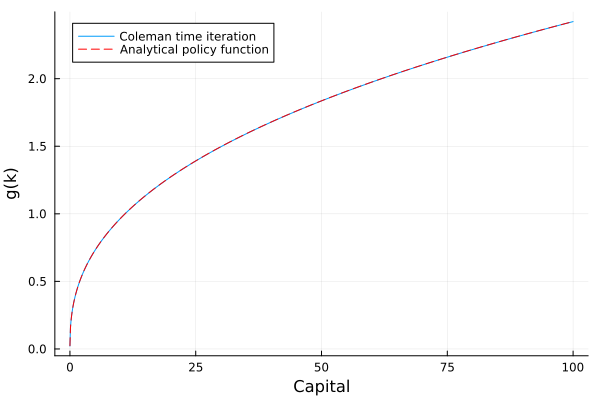

In [21]:
plot(p.kgrid, polV, label="Coleman time iteration", 
    xlabel="Capital", ylabel="g(k)")

pol_analytical(k) = p.α*p.β*k^p.α

plot!(p.kgrid, pol_analytical.(p.kgrid), label="Analytical policy function", 
    linestyle=:dash, color=:red)

In [25]:
polF = CubicSplineInterpolation(p.kgrid, polV)

function compute_euler_residual(k::Float64)
    k′ = polF(k)
    c = p.f(k) - k′
    k′′ = polF(k′)
    c′ = p.f(k′) - k′′
    RHS = p.β * p.f_k(k′) * p.u_c(c′)
    return log10(abs(1 - (p.u_c(RHS)/c)))
end

kfineV = range(p.kmin, p.kmax, length=5_001)
errorsV = compute_euler_residual.(kfineV)

using Statistics

mean(errorsV)

-7.0007036990220834

In [27]:
10^(-mean(errorsV))

1.0016216403171042e7

PFI is not only significantly faster than VFI, it has also resulted in much more accurate policy functions too! With the policy function from PFI, the agent is now making a $\$1$ mistake for over every $\$10$ million! 

When speed becomes critical, you should always find and exploit as many model-specific mathematical short-cuts as you can. By iterating on the Euler equation, which uses much more information about the problem than the Bellman equation, we are rewarded with BOTH a speed-up by almost an entire order of magnitude and an increase in accuracy!